**准备训练和测试的数据**

In [7]:
!python dataset_preprocess.py --patch_size 32 --step 32

(6736, 8515, 3)
374
(2618, 1, 32, 32) (51238, 1, 32, 32)
(2618, 32, 32, 3) (51238, 32, 32, 3)
(2618, 1, 32, 32) (51238, 1, 32, 32)


**网络组件和网络结构**

*网络组件*

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class conv2DBatchNorm(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cb_unit = nn.Sequential(conv_mod, nn.BatchNorm2d(int(n_filters)))
        else:
            self.cb_unit = nn.Sequential(conv_mod)

    def forward(self, inputs):
        outputs = self.cb_unit(inputs)
        return outputs


class conv2DGroupNorm(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNorm, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cg_unit = nn.Sequential(conv_mod, nn.GroupNorm(n_groups, int(n_filters)))

    def forward(self, inputs):
        outputs = self.cg_unit(inputs)
        return outputs


class deconv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNorm, self).__init__()

        self.dcb_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
        )

    def forward(self, inputs):
        outputs = self.dcb_unit(inputs)
        return outputs


class conv2DBatchNormRelu(nn.Module):
    def __init__(
        self,
        in_channels,
        n_filters,
        k_size,
        stride,
        padding,
        bias=True,
        dilation=1,
        is_batchnorm=True,
    ):
        super(conv2DBatchNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        if is_batchnorm:
            self.cbr_unit = nn.Sequential(
                conv_mod, nn.BatchNorm2d(int(n_filters)), nn.ReLU(inplace=True)
            )
        else:
            self.cbr_unit = nn.Sequential(conv_mod, nn.ReLU(inplace=True))

    def forward(self, inputs):
        outputs = self.cbr_unit(inputs)
        return outputs


class conv2DGroupNormRelu(nn.Module):
    def __init__(
        self, in_channels, n_filters, k_size, stride, padding, bias=True, dilation=1, n_groups=16
    ):
        super(conv2DGroupNormRelu, self).__init__()

        conv_mod = nn.Conv2d(
            int(in_channels),
            int(n_filters),
            kernel_size=k_size,
            padding=padding,
            stride=stride,
            bias=bias,
            dilation=dilation,
        )

        self.cgr_unit = nn.Sequential(
            conv_mod, nn.GroupNorm(n_groups, int(n_filters)), nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        outputs = self.cgr_unit(inputs)
        return outputs


class deconv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, n_filters, k_size, stride, padding, bias=True):
        super(deconv2DBatchNormRelu, self).__init__()

        self.dcbr_unit = nn.Sequential(
            nn.ConvTranspose2d(
                int(in_channels),
                int(n_filters),
                kernel_size=k_size,
                padding=padding,
                stride=stride,
                bias=bias,
            ),
            nn.BatchNorm2d(int(n_filters)),
            nn.ReLU(inplace=True),
        )

    def forward(self, inputs):
        outputs = self.dcbr_unit(inputs)
        return outputs


class segnetDown2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown2, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetDown3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetDown3, self).__init__()
        self.conv1 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(out_size, out_size, 3, 1, 1)
        self.maxpool_with_argmax = nn.MaxPool2d(2, 2, return_indices=True)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        unpooled_shape = outputs.size()
        outputs, indices = self.maxpool_with_argmax(outputs)
        return outputs, indices, unpooled_shape


class segnetUp2(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp2, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        return outputs


class segnetUp3(nn.Module):
    def __init__(self, in_size, out_size):
        super(segnetUp3, self).__init__()
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.conv1 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv2 = conv2DBatchNormRelu(in_size, in_size, 3, 1, 1)
        self.conv3 = conv2DBatchNormRelu(in_size, out_size, 3, 1, 1)

    def forward(self, inputs, indices, output_shape):
        outputs = self.unpool(input=inputs, indices=indices, output_size=output_shape)
        outputs = self.conv1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.conv3(outputs)
        return outputs

*网络结构*

In [9]:
import torch.nn as nn
#from netutils import segnetDown2, segnetDown3, segnetUp2, segnetUp3


class segnet(nn.Module):
    def __init__(self, n_classes=21, in_channels=3, is_unpooling=True):
        super(segnet, self).__init__()

        self.in_channels = in_channels
        self.is_unpooling = is_unpooling
        self.down1 = segnetDown2(self.in_channels, 64)
        self.down2 = segnetDown2(64, 128)
        self.down3 = segnetDown3(128, 256)
        self.down4 = segnetDown3(256, 512)
        self.down5 = segnetDown3(512, 512) # not used
        for p in self.parameters():
            p.requires_grad = True
        self.up5 = segnetUp3(512, 512) # not used
        self.up4 = segnetUp3(512, 256)
        self.up3 = segnetUp3(256, 128)
        self.up2 = segnetUp2(128, 64)
        self.up1 = segnetUp2(64, n_classes)

    def forward(self, inputs):

        down1, indices_1, unpool_shape1 = self.down1(inputs)
        down2, indices_2, unpool_shape2 = self.down2(down1)
        down3, indices_3, unpool_shape3 = self.down3(down2)
        down4, indices_4, unpool_shape4 = self.down4(down3)
        down5, indices_5, unpool_shape5 = self.down5(down4)
        
        up5 = self.up5(down5, indices_5, unpool_shape5) # not used
        up4 = self.up4(up5, indices_4, unpool_shape4)
        up3 = self.up3(up4, indices_3, unpool_shape3)
        up2 = self.up2(up3, indices_2, unpool_shape2)
        up1 = self.up1(up2, indices_1, unpool_shape1)
        return up1
#如果编码器部分不改变的话则可以利用VGG16的参数初始化网络（且训练的时候并没有改变这些参数），注意并没有初始化uplayer的参数
    def init_vgg16_params(self, vgg16):
        blocks = [self.down1, self.down2, self.down3, self.down4, self.down5]

        features = list(vgg16.features.children())

        vgg_layers = []
        for _layer in features:
            if isinstance(_layer, nn.Conv2d):
                vgg_layers.append(_layer)

        merged_layers = []
        for idx, conv_block in enumerate(blocks):
            if idx < 2:
                units = [conv_block.conv1.cbr_unit, conv_block.conv2.cbr_unit]
            else:
                units = [
                    conv_block.conv1.cbr_unit,
                    conv_block.conv2.cbr_unit,
                    conv_block.conv3.cbr_unit,
                ]
            for _unit in units:
                for _layer in _unit:
                    if isinstance(_layer, nn.Conv2d):
                        merged_layers.append(_layer)

        assert len(vgg_layers) == len(merged_layers)

        for l1, l2 in zip(vgg_layers, merged_layers):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data

**Training**

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torchvision.models as models
import torch.utils.data as data
import sklearn.metrics as metrics
# from netutils import *
# from segnet import *
# from mytictoc import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
patch_size = 32
class config():
    patch_size = 32
    step = 32
    lr = 0.05
    weight_decay = 0.0005
    num_class = 5
    epoch = 80
    batch_size = 500
    momentum = 0.9
opt = config()

start!!


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:10<00:00, 52568526.31it/s]


total epoch num is 80
current epoch:0;  train loss:1.5578383;  train acc:0.2682794348075565;  eval loss:1.5316556;  eval acc:0.5639471338892962
validation loss decreases...


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type segnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type segnetDown2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type conv2DBatchNormRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type segnetDown3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/cond

current epoch:1;  train loss:1.3150523;  train acc:0.6107220493467514;  eval loss:1.3684666;  eval acc:0.5664797585227271
validation loss decreases...
current epoch:2;  train loss:1.166938;  train acc:0.6317656360346046;  eval loss:1.2843099;  eval acc:0.5696498464992668
validation loss decreases...
current epoch:3;  train loss:1.0126544;  train acc:0.7071543299788136;  eval loss:1.2919371;  eval acc:0.5725943456744867
1epochs of increasing val loss
current epoch:4;  train loss:0.9453277;  train acc:0.7151785564530367;  eval loss:1.3342907;  eval acc:0.569554011638563
2epochs of increasing val loss
current epoch:5;  train loss:0.8912663;  train acc:0.7267237707450565;  eval loss:1.3511481;  eval acc:0.5649490927419355
3epochs of increasing val loss
current epoch:6;  train loss:0.87136817;  train acc:0.7222760527012713;  eval loss:1.208771;  eval acc:0.5676413123167156
validation loss decreases...
current epoch:7;  train loss:0.8330962;  train acc:0.7305094842425848;  eval loss:1.163953

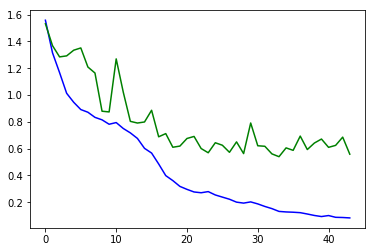

end!!


In [11]:
class MyTrainData(data.Dataset):
    def __init__(self, image, label):
        self.image = image
        self.label = label
    def __len__(self):
        return len(self.image)
        print(len(self.image))
    def __getitem__(self,index):
        img, lb = self.image[index],self.label[index]
        return img,lb
#获取loader
def getloader(image,label,batch_size = opt.batch_size, shuffle = False):
    label = label.astype(np.int64)
    dataset = MyTrainData(image,label)
    loader = data.DataLoader(dataset,batch_size = batch_size, shuffle = shuffle)
    return loader

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by x every y epochs"""
    lr = opt.lr * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


#定义损失函数，方便计算loss
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0), input.size(1), -1)
        output = torch.transpose(output, 1, 2).contiguous()
        output = output.view(-1, output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target, weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def get_loss():
    return CrossEntropy2d
        

def train(model, train_loader,eval_loader, myloss, optimizer,epoches):
    train_losses = []
    eval_losses = []
    train_acc = []
    eval_acc = []
    #提前停止参数
    p = 0
    patience = 10
    valid_loss_min = np.Inf
    stop = False

    for epoch in range(epoches):
        
        adjust_learning_rate(optimizer,epoch)
        train_losses_temp = []
        eval_losses_temp = []
        train_acc_temp = []
        eval_acc_temp = []
        model.train()        

        for i, [images,labels] in enumerate(train_loader):

            images = Variable(images.type(torch.FloatTensor)).cuda()
            labels = Variable(labels.type(torch.LongTensor)).cuda()
            optimizer.zero_grad()

            output = model(images)
            pred = np.expand_dims(np.argmax(output.data.cpu().numpy(), axis=1),axis=1)

            loss = myloss(output,labels)
            train_losses_temp.append(loss.data.cpu().numpy())

            acc = accuracy_score(labels.data.cpu().numpy().flatten(),pred.flatten())
            train_acc_temp.append(acc)

            loss.backward()
            optimizer.step()
            del images
            del labels

        train_losses.append(np.mean(train_losses_temp))
        train_acc.append(np.mean(train_acc_temp))

        model.eval()
        for i, [images,labels] in enumerate(eval_loader):

            images = Variable(images.type(torch.FloatTensor)).cuda()
            labels = Variable(labels.type(torch.LongTensor)).cuda()

            output = model(images)
            pred = np.expand_dims(np.argmax(output.data.cpu().numpy(), axis=1),axis=1)#pred shape: (batch_size,1,patch_size,patch_size)

            loss = myloss(output,labels)
            eval_losses_temp.append(loss.data.cpu().numpy())

            acc = accuracy_score(labels.data.cpu().numpy().flatten(),pred.flatten())
            eval_acc_temp.append(acc)
            del images
            del labels
        eval_losses.append(np.mean(eval_losses_temp))
        eval_acc.append(np.mean(eval_acc_temp))
        print("current epoch:"+str(epoch)+";  train loss:"+str(train_losses[epoch])\
              +";  train acc:"+str(train_acc[epoch])+";  eval loss:"+str(eval_losses[epoch])+";  eval acc:"+str(eval_acc[epoch]))

        if eval_losses[epoch] <= valid_loss_min:
            print("validation loss decreases...") 
            torch.save(model, 'temp.pkl') 
            valid_loss_min = eval_losses[epoch]
            p = 0
        if eval_losses[epoch] > valid_loss_min:
            p += 1
            print(str(p)+"epochs of increasing val loss")
            if p >= patience:
                print("Out of patience, stopping training... ")
                stop = True
        if stop:
            break
    print(train_losses)
    print(eval_losses)
    plt.plot(train_losses,'b-')
    plt.plot(eval_losses, 'g-')
    plt.show()

def main():

    print("start!!")
    model = segnet(n_classes=opt.num_class, in_channels=3, is_unpooling=True).cuda()
    
    debug_mode = False #debug时不加载预训练模型，令它为True
    print_model = False #需要看模型结构时为True
    
    if debug_mode == False:
        vgg16net = models.vgg16(pretrained=True).cuda()
        model.init_vgg16_params(vgg16net)    
        if print_model == True:
            print(model)


    data1 = np.load('train_data_x_patch_'+str(opt.patch_size)+'.npy').astype(np.float32)
    data_train = np.concatenate((data1,data1,data1),axis =1)
    del data1
    label_train = np.load('train_data_y_patch_'+str(opt.patch_size)+'_numerical.npy')
    data1 = np.load('test_data_x_patch_'+str(opt.patch_size)+'.npy').astype(np.float32)
    data_test = np.concatenate((data1,data1,data1),axis =1)
    del data1
    label_test = np.load('test_data_y_patch_'+str(opt.patch_size)+'_numerical.npy')
    

    
    X_, data_eval, y_, label_eval = train_test_split(data_test,label_test,test_size=0.1,random_state=11)
    del X_, y_, data_test, label_test

    
    myloss= get_loss()
    myoptimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),lr = opt.lr,weight_decay = opt.weight_decay, momentum = opt.momentum)
    train_loader = getloader(data_train,label_train, batch_size = opt.batch_size, shuffle = True)
    eval_loader = getloader(data_eval,label_eval, batch_size = opt.batch_size, shuffle = True)
    for epoch in [opt.epoch]:
        print('total epoch num is %d'%epoch)
        train(model, train_loader, eval_loader, myloss, myoptimizer, epoch)
    #torch.save(model, 'temp.pkl') 
    print("end!!")

main()

**测试**

In [12]:
opt = config()

data1 = np.load('test_data_x_patch_'+str(opt.patch_size)+'.npy').astype(np.float32)
data_test = np.concatenate((data1,data1,data1),axis =1)
del data1
print(data_test.shape)


model = torch.load('temp.pkl')
model.eval()


data_temp = np.zeros((1,3,opt.patch_size,opt.patch_size)).astype(np.float32)
test_out = np.zeros((data_test.shape[0],5,opt.patch_size,opt.patch_size))


for i in range(data_test.shape[0]):
    data_temp[0,:,:,:] = data_test[i,:,:,:]
    data_temp_v = Variable(torch.from_numpy(data_temp)).cuda()
    temp_out = model(data_temp_v)
    temp_out_a = temp_out.cpu().data.numpy()
    test_out[i,:,:,:] = temp_out_a
    del data_temp_v
    del temp_out
    del temp_out_a
    
    if i%1000 == 0:
        print(i)
        
del data_temp    

test_result = np.argmax(test_out,axis = 1)
np.save('test_result_'+str(opt.patch_size),test_result)
print('done!')

(51238, 3, 32, 32)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
done!


In [13]:
test_result = np.load('test_result_'+str(opt.patch_size)+".npy").astype(np.int32)
test_result.resize((test_result.shape[0]*test_result.shape[1]*test_result.shape[2]))
test_label = np.load('test_data_y_patch_'+str(opt.patch_size)+'_numerical.npy').astype(np.int32).squeeze()
test_label.resize((test_label.shape[0]*test_label.shape[1]*test_label.shape[2]))
print(np.sum(test_label==1))

from sklearn.metrics import classification_report
target_name = [ 'river','urban','farmland','background','non-image']

print(classification_report(test_label,test_result,target_names = target_name,digits=4))

3734306
              precision    recall  f1-score   support

       river     0.6662    0.8165    0.7337   6536490
       urban     0.6788    0.5361    0.5991   3734306
    farmland     0.6849    0.6567    0.6705   3168694
  background     0.8801    0.8628    0.8714  29677404
   non-image     0.9845    0.9872    0.9858   9350818

    accuracy                         0.8435  52467712
   macro avg     0.7789    0.7718    0.7721  52467712
weighted avg     0.8460    0.8435    0.8431  52467712

